In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py

from sklearn.metrics import average_precision_score, roc_auc_score

#Function to do a number of permuted average precision calculations
def permute_ap_auc(df_snp_pos_in, df_snp_neg_in, frac_sample=0.8, n_shuffles=1000) :
    
    df_snp_pos = df_snp_pos_in.copy()
    df_snp_neg = df_snp_neg_in.copy()
    
    df_snp_pos['is_causal'] = 1
    df_snp_neg['is_causal'] = 0

    shuffle_index_pos = np.arange(len(df_snp_pos))

    aps_borzoi = []
    aps_saluki = []

    aucs_borzoi = []
    aucs_saluki = []

    for shuffle_ix in range(n_shuffles) :

        np.random.shuffle(shuffle_index_pos)
        df_snp_pos_shuffled = df_snp_pos.iloc[shuffle_index_pos].copy().reset_index(drop=True)

        #Sample positives
        df_snp_pos_shuffled = df_snp_pos_shuffled.iloc[:int(frac_sample * len(df_snp_pos_shuffled))].copy().reset_index(drop=True)
        
        #Select matched negatives
        df_snp_neg_shuffled = df_snp_neg.loc[df_snp_neg['matched_snp'].isin(df_snp_pos_shuffled['matched_snp'])].copy().reset_index(drop=True)

        df_snp = pd.concat([df_snp_pos_shuffled, df_snp_neg_shuffled])

        score_borzoi = np.abs(np.array(df_snp['delta_score_borzoi'].values))
        score_saluki = np.abs(np.array(df_snp['SSD0'].values))
        label = np.array(df_snp['is_causal'].values)

        #Precision-recall scores
        ap_borzoi = average_precision_score(label, score_borzoi)
        ap_saluki = average_precision_score(label, score_saluki)
        
        aps_borzoi.append(ap_borzoi)
        aps_saluki.append(ap_saluki)

        #Area under ROC curve
        auc_borzoi = roc_auc_score(label, score_borzoi)
        auc_saluki = roc_auc_score(label, score_saluki)
        
        aucs_borzoi.append(auc_borzoi)
        aucs_saluki.append(auc_saluki)
    
    ap_bundle = [
        [np.quantile(aps_borzoi, q=0.10), np.mean(aps_borzoi), np.quantile(aps_borzoi, q=0.90)],
        [np.quantile(aps_saluki, q=0.10), np.mean(aps_saluki), np.quantile(aps_saluki, q=0.90)]
    ]
    auc_bundle = [
        [np.quantile(aucs_borzoi, q=0.10), np.mean(aucs_borzoi), np.quantile(aucs_borzoi, q=0.90)],
        [np.quantile(aucs_saluki, q=0.10), np.mean(aucs_saluki), np.quantile(aucs_saluki, q=0.90)]
    ]
    
    return [ap_bundle, auc_bundle]


In [2]:
#Inflate pos predictions

def inflate_snp_predictions(pos_or_neg, fold_index=[0, 1], fold_suffixes=['', '']) :

    print("Inflating predictions for '" + pos_or_neg + "'.")
    
    df_folds = []
    
    sed_scores = None

    for fold_i, [fold_ix, fold_suffix] in enumerate(zip(fold_index, fold_suffixes)) :

        sed = h5py.File('models/f' + str(fold_ix) + 'c0' + fold_suffix + '/complex_3prime/merge_' + pos_or_neg + '/sed.h5', 'r')
        
        gene_id_mat = sed['gene'][()]
        snp_mat = sed['snp'][()]
        chr_mat = sed['chr'][()]
        pos_mat = sed['pos'][()]
        score_mat = sed['logSED'][()]
        ref_allele_mat = sed['ref_allele'][()]
        alt_allele_mat = sed['alt_allele'][()]
        
        if fold_i == 0 :
            sed_scores = np.abs(score_mat.copy())
        else :
            sed_scores += np.abs(score_mat.copy())
        
        gene_ids = []
        snps = []
        chroms = []
        poses = []
        preds = []
        ref_alleles = []
        alt_alleles = []

        for i, si in enumerate(sed['si'][()].tolist()) :

            gene_ids.append(gene_id_mat[i].decode())
            snps.append(snp_mat[si].decode())
            chroms.append(chr_mat[si].decode())
            poses.append(int(pos_mat[si]))

            preds.append(np.mean(np.abs(score_mat[i, :])))

            ref_alleles.append(ref_allele_mat[si].decode())
            alt_alleles.append(alt_allele_mat[si].decode())

        df = pd.DataFrame({
            'gene_id_pred' : gene_ids,
            'snp' : snps,
            'chrom' : chroms,
            'pos' : poses,
            'delta_score' : preds,
        })

        print("len(df) = " + str(len(df)))

        df_folds.append(df)

    df = df_folds[0]
    df = df.rename(columns={'delta_score' : 'delta_score_0'})
    df['delta_score'] = df['delta_score_0']
    
    for i in range(1, len(df_folds)) :

        df['delta_score_' + str(i)] = df_folds[i]['delta_score']
        df['delta_score'] += df['delta_score_' + str(i)]
        
    df['delta_score'] /= float(len(df_folds))
    
    sed_scores /= float(len(df_folds))
    
    df['row_index'] = np.arange(len(df), dtype=np.int32)
    
    #Get finemapped gene id and distance
    vcf_df = pd.read_csv('/home/jlinder/seqnn/data/traitgym/complex_3prime/' + pos_or_neg + '_merge.vcf', sep='\t', skiprows=3)
    
    vcf_df['min_dist'] = vcf_df['INFO'].apply(lambda x: x.split("DI=")[1].split(";")[0]).astype(int)
    vcf_df['matched_snp'] = vcf_df['INFO'].apply(lambda x: x.split("MG=")[1].split(";")[0])
    
    df = df.join(vcf_df[['ID', 'min_dist', 'matched_snp']].set_index('ID'), on='snp', how='inner').copy().reset_index(drop=True)
    
    df.loc[df['delta_score'].isnull(), 'delta_score'] = 0.
    
    return df, sed_scores

df_snp_pos, scores_pos = inflate_snp_predictions('pos', [0, 1], ['', ''])
df_snp_neg, scores_neg = inflate_snp_predictions('neg', [0, 1], ['', ''])

#Rename borzoi VEP score
df_snp_pos = df_snp_pos.rename(columns={'delta_score' : 'delta_score_borzoi'})
df_snp_neg = df_snp_neg.rename(columns={'delta_score' : 'delta_score_borzoi'})

#Get target ids
target_ids = h5py.File('models/f0c0/gtexg/merge_pos/sed.h5', 'r')['target_ids'][()]
target_ids = [tid.decode() for tid in target_ids.tolist()]

target_name_dict = pd.read_csv('targets_human_rna.txt', sep='\t')[['identifier', 'description']].set_index('identifier').to_dict(orient='index')

target_names = []
for tid in target_ids :
    target_names.append(target_name_dict[tid]['description'])

#Filter on matched gene
'''
df_snp_pos['gene_id_base'] = df_snp_pos['gene_id_pred'].apply(lambda x: x.split(".")[0])
df_snp_neg['gene_id_base'] = df_snp_neg['gene_id_pred'].apply(lambda x: x.split(".")[0])

df_snp_pos = df_snp_pos.query("gene_id_base == finemap_gene_id").copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.query("gene_id_base == finemap_gene_id").copy().reset_index(drop=True)
'''

#Filter on max score
df_snp_pos = df_snp_pos.sort_values(by=['delta_score_borzoi'], ascending=False).drop_duplicates(subset=['snp'], keep='first').copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.sort_values(by=['delta_score_borzoi'], ascending=False).drop_duplicates(subset=['snp'], keep='first').copy().reset_index(drop=True)

scores_pos = scores_pos[df_snp_pos['row_index'].values.tolist(), :]
scores_neg = scores_neg[df_snp_neg['row_index'].values.tolist(), :]

#Append saluki ensemble predictions

df_saluki_pos = None
df_saluki_neg = None
for fold_ix in range(10) :
    for cross_ix in range(5) :
        df_saluki_pos_curr = pd.read_csv('/home/jlinder/analysis/saluki/complex_3prime/f' + str(fold_ix) + 'c' + str(cross_ix) + '/pos_merge/ssd.tsv', sep='\t')
        df_saluki_neg_curr = pd.read_csv('/home/jlinder/analysis/saluki/complex_3prime/f' + str(fold_ix) + 'c' + str(cross_ix) + '/neg_merge/ssd.tsv', sep='\t')
        
        df_saluki_pos_curr['SSD0'] = np.abs(df_saluki_pos_curr['SSD0'])
        df_saluki_neg_curr['SSD0'] = np.abs(df_saluki_neg_curr['SSD0'])
        
        if df_saluki_pos is None :
            df_saluki_pos = df_saluki_pos_curr.copy()
            df_saluki_neg = df_saluki_neg_curr.copy()
        else :
            df_saluki_pos['SSD0'] += df_saluki_pos_curr['SSD0'] / 50.
            df_saluki_neg['SSD0'] += df_saluki_neg_curr['SSD0'] / 50.

#df_saluki_pos['SSD0'] = np.abs(df_saluki_pos['SSD0'])
#df_saluki_neg['SSD0'] = np.abs(df_saluki_neg['SSD0'])

#Drop duplicate variants
df_saluki_pos = df_saluki_pos.groupby('variant').agg({'SSD0' : 'max'}).copy().reset_index()
df_saluki_neg = df_saluki_neg.groupby('variant').agg({'SSD0' : 'max'}).copy().reset_index()

df_snp_pos = df_snp_pos.join(df_saluki_pos.set_index('variant'), on='snp', how='inner').copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.join(df_saluki_neg.set_index('variant'), on='snp', how='inner').copy().reset_index(drop=True)

#Filter negatives without matching positive
df_snp_neg = df_snp_neg.loc[df_snp_neg['matched_snp'].isin(df_snp_pos['matched_snp'])].copy().reset_index(drop=True)

#Sort by SNP
df_snp_pos = df_snp_pos.sort_values(by=['snp'], ascending=True).copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.sort_values(by=['snp'], ascending=True).copy().reset_index(drop=True)

print("")
print("len(len(df_snp_pos)) = " + str(len(df_snp_pos)))
print("len(len(df_snp_neg)) = " + str(len(df_snp_neg)))

#Evaluate SNP classification performance based on scalar effect size predictions

df_snp_pos['is_causal'] = 1
df_snp_neg['is_causal'] = 0
df_snp = pd.concat([df_snp_pos, df_snp_neg])

score_borzoi = np.abs(np.array(df_snp['delta_score_borzoi'].values))
score_saluki = np.abs(np.array(df_snp['SSD0'].values))
label = np.array(df_snp['is_causal'].values)

#Precision-recall scores
ap_borzoi = average_precision_score(label, score_borzoi)
ap_saluki = average_precision_score(label, score_saluki)

#Area under ROC curve
auc_borzoi = roc_auc_score(label, score_borzoi)
auc_saluki = roc_auc_score(label, score_saluki)

print("")
print('ap_borzoi  = %.3f' % ap_borzoi)
print('ap_saluki  = %.3f' % ap_saluki)

print("")
print('auc_borzoi = %.3f' % auc_borzoi)
print('auc_saluki = %.3f' % auc_saluki)

#Evaluate SNP classification performance based on scalar effect size predictions, permutation

ap_bundle, auc_bundle = permute_ap_auc(df_snp_pos, df_snp_neg)

[ap_borzoi_lo, ap_borzoi_mean, ap_borzoi_hi], [ap_saluki_lo, ap_saluki_mean, ap_saluki_hi] = ap_bundle
[auc_borzoi_lo, auc_borzoi_mean, auc_borzoi_hi], [auc_saluki_lo, auc_saluki_mean, auc_saluki_hi] = auc_bundle

print("")
print(('ap_borzoi_mean  = %.3f' % ap_borzoi_mean) + (' [%.3f' % ap_borzoi_lo) + (', %.3f' % ap_borzoi_hi) + ']')
print(('ap_saluki_mean  = %.3f' % ap_saluki_mean) + (' [%.3f' % ap_saluki_lo) + (', %.3f' % ap_saluki_hi) + ']')

print("")
print(('auc_borzoi_mean = %.3f' % auc_borzoi_mean) + (' [%.3f' % auc_borzoi_lo) + (', %.3f' % auc_borzoi_hi) + ']')
print(('auc_saluki_mean = %.3f' % auc_saluki_mean) + (' [%.3f' % auc_saluki_lo) + (', %.3f' % auc_saluki_hi) + ']')


Inflating predictions for 'pos'.
len(df) = 944
len(df) = 944
Inflating predictions for 'neg'.
len(df) = 7550
len(df) = 7550

len(len(df_snp_pos)) = 46
len(len(df_snp_neg)) = 350

ap_borzoi  = 0.270
ap_saluki  = 0.220

auc_borzoi = 0.703
auc_saluki = 0.668

ap_borzoi_mean  = 0.275 [0.243, 0.306]
ap_saluki_mean  = 0.223 [0.196, 0.252]

auc_borzoi_mean = 0.703 [0.677, 0.729]
auc_saluki_mean = 0.667 [0.638, 0.696]


In [3]:
#Inflate pos predictions

def inflate_snp_predictions(pos_or_neg, fold_index=[0, 1], fold_suffixes=['', '']) :

    print("Inflating predictions for '" + pos_or_neg + "'.")
    
    df_folds = []
    
    sed_scores = None

    for fold_i, [fold_ix, fold_suffix] in enumerate(zip(fold_index, fold_suffixes)) :

        sed = h5py.File('models/f' + str(fold_ix) + 'c0' + fold_suffix + '/mendelian_3prime/merge_' + pos_or_neg + '/sed.h5', 'r')
        
        gene_id_mat = sed['gene'][()]
        snp_mat = sed['snp'][()]
        chr_mat = sed['chr'][()]
        pos_mat = sed['pos'][()]
        score_mat = sed['logSED'][()]
        ref_allele_mat = sed['ref_allele'][()]
        alt_allele_mat = sed['alt_allele'][()]
        
        if fold_i == 0 :
            sed_scores = np.abs(score_mat.copy())
        else :
            sed_scores += np.abs(score_mat.copy())
        
        gene_ids = []
        snps = []
        chroms = []
        poses = []
        preds = []
        ref_alleles = []
        alt_alleles = []

        for i, si in enumerate(sed['si'][()].tolist()) :

            gene_ids.append(gene_id_mat[i].decode())
            snps.append(snp_mat[si].decode())
            chroms.append(chr_mat[si].decode())
            poses.append(int(pos_mat[si]))

            preds.append(np.mean(np.abs(score_mat[i, :])))

            ref_alleles.append(ref_allele_mat[si].decode())
            alt_alleles.append(alt_allele_mat[si].decode())

        df = pd.DataFrame({
            'gene_id_pred' : gene_ids,
            'snp' : snps,
            'chrom' : chroms,
            'pos' : poses,
            'delta_score' : preds,
        })

        print("len(df) = " + str(len(df)))

        df_folds.append(df)

    df = df_folds[0]
    df = df.rename(columns={'delta_score' : 'delta_score_0'})
    df['delta_score'] = df['delta_score_0']
    
    for i in range(1, len(df_folds)) :

        df['delta_score_' + str(i)] = df_folds[i]['delta_score']
        df['delta_score'] += df['delta_score_' + str(i)]
        
    df['delta_score'] /= float(len(df_folds))
    
    sed_scores /= float(len(df_folds))
    
    df['row_index'] = np.arange(len(df), dtype=np.int32)
    
    #Get finemapped gene id and distance
    vcf_df = pd.read_csv('/home/jlinder/seqnn/data/traitgym/mendelian_3prime/' + pos_or_neg + '_merge.vcf', sep='\t', skiprows=3)
    
    vcf_df['min_dist'] = vcf_df['INFO'].apply(lambda x: x.split("DI=")[1].split(";")[0]).astype(int)
    vcf_df['matched_snp'] = vcf_df['INFO'].apply(lambda x: x.split("MG=")[1].split(";")[0])
    
    df = df.join(vcf_df[['ID', 'min_dist', 'matched_snp']].set_index('ID'), on='snp', how='inner').copy().reset_index(drop=True)
    
    df.loc[df['delta_score'].isnull(), 'delta_score'] = 0.
    
    return df, sed_scores

df_snp_pos, scores_pos = inflate_snp_predictions('pos', [0, 1], ['', ''])
df_snp_neg, scores_neg = inflate_snp_predictions('neg', [0, 1], ['', ''])

#Rename borzoi VEP score
df_snp_pos = df_snp_pos.rename(columns={'delta_score' : 'delta_score_borzoi'})
df_snp_neg = df_snp_neg.rename(columns={'delta_score' : 'delta_score_borzoi'})

#Get target ids
target_ids = h5py.File('models/f0c0/gtexg/merge_pos/sed.h5', 'r')['target_ids'][()]
target_ids = [tid.decode() for tid in target_ids.tolist()]

target_name_dict = pd.read_csv('targets_human_rna.txt', sep='\t')[['identifier', 'description']].set_index('identifier').to_dict(orient='index')

target_names = []
for tid in target_ids :
    target_names.append(target_name_dict[tid]['description'])

#Filter on matched gene
'''
df_snp_pos['gene_id_base'] = df_snp_pos['gene_id_pred'].apply(lambda x: x.split(".")[0])
df_snp_neg['gene_id_base'] = df_snp_neg['gene_id_pred'].apply(lambda x: x.split(".")[0])

df_snp_pos = df_snp_pos.query("gene_id_base == finemap_gene_id").copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.query("gene_id_base == finemap_gene_id").copy().reset_index(drop=True)
'''

#Filter on max score
df_snp_pos = df_snp_pos.sort_values(by=['delta_score_borzoi'], ascending=False).drop_duplicates(subset=['snp'], keep='first').copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.sort_values(by=['delta_score_borzoi'], ascending=False).drop_duplicates(subset=['snp'], keep='first').copy().reset_index(drop=True)

scores_pos = scores_pos[df_snp_pos['row_index'].values.tolist(), :]
scores_neg = scores_neg[df_snp_neg['row_index'].values.tolist(), :]

#Append saluki ensemble predictions

df_saluki_pos = None
df_saluki_neg = None
for fold_ix in range(10) :
    for cross_ix in range(5) :
        df_saluki_pos_curr = pd.read_csv('/home/jlinder/analysis/saluki/mendelian_3prime/f' + str(fold_ix) + 'c' + str(cross_ix) + '/pos_merge/ssd.tsv', sep='\t')
        df_saluki_neg_curr = pd.read_csv('/home/jlinder/analysis/saluki/mendelian_3prime/f' + str(fold_ix) + 'c' + str(cross_ix) + '/neg_merge/ssd.tsv', sep='\t')
        
        df_saluki_pos_curr['SSD0'] = np.abs(df_saluki_pos_curr['SSD0'])
        df_saluki_neg_curr['SSD0'] = np.abs(df_saluki_neg_curr['SSD0'])
        
        if df_saluki_pos is None :
            df_saluki_pos = df_saluki_pos_curr.copy()
            df_saluki_neg = df_saluki_neg_curr.copy()
        else :
            df_saluki_pos['SSD0'] += df_saluki_pos_curr['SSD0'] / 50.
            df_saluki_neg['SSD0'] += df_saluki_neg_curr['SSD0'] / 50.

#df_saluki_pos['SSD0'] = np.abs(df_saluki_pos['SSD0'])
#df_saluki_neg['SSD0'] = np.abs(df_saluki_neg['SSD0'])

#Drop duplicate variants
df_saluki_pos = df_saluki_pos.groupby('variant').agg({'SSD0' : 'max'}).copy().reset_index()
df_saluki_neg = df_saluki_neg.groupby('variant').agg({'SSD0' : 'max'}).copy().reset_index()

df_snp_pos = df_snp_pos.join(df_saluki_pos.set_index('variant'), on='snp', how='inner').copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.join(df_saluki_neg.set_index('variant'), on='snp', how='inner').copy().reset_index(drop=True)

#Filter negatives without matching positive
df_snp_neg = df_snp_neg.loc[df_snp_neg['matched_snp'].isin(df_snp_pos['matched_snp'])].copy().reset_index(drop=True)

#Sort by SNP
df_snp_pos = df_snp_pos.sort_values(by=['snp'], ascending=True).copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.sort_values(by=['snp'], ascending=True).copy().reset_index(drop=True)

print("")
print("len(len(df_snp_pos)) = " + str(len(df_snp_pos)))
print("len(len(df_snp_neg)) = " + str(len(df_snp_neg)))

#Evaluate SNP classification performance based on scalar effect size predictions

df_snp_pos['is_causal'] = 1
df_snp_neg['is_causal'] = 0
df_snp = pd.concat([df_snp_pos, df_snp_neg])

score_borzoi = np.abs(np.array(df_snp['delta_score_borzoi'].values))
score_saluki = np.abs(np.array(df_snp['SSD0'].values))
label = np.array(df_snp['is_causal'].values)

#Precision-recall scores
ap_borzoi = average_precision_score(label, score_borzoi)
ap_saluki = average_precision_score(label, score_saluki)

#Area under ROC curve
auc_borzoi = roc_auc_score(label, score_borzoi)
auc_saluki = roc_auc_score(label, score_saluki)

print("")
print('ap_borzoi  = %.3f' % ap_borzoi)
print('ap_saluki  = %.3f' % ap_saluki)

print("")
print('auc_borzoi = %.3f' % auc_borzoi)
print('auc_saluki = %.3f' % auc_saluki)

#Evaluate SNP classification performance based on scalar effect size predictions, permutation

ap_bundle, auc_bundle = permute_ap_auc(df_snp_pos, df_snp_neg)

[ap_borzoi_lo, ap_borzoi_mean, ap_borzoi_hi], [ap_saluki_lo, ap_saluki_mean, ap_saluki_hi] = ap_bundle
[auc_borzoi_lo, auc_borzoi_mean, auc_borzoi_hi], [auc_saluki_lo, auc_saluki_mean, auc_saluki_hi] = auc_bundle

print("")
print(('ap_borzoi_mean  = %.3f' % ap_borzoi_mean) + (' [%.3f' % ap_borzoi_lo) + (', %.3f' % ap_borzoi_hi) + ']')
print(('ap_saluki_mean  = %.3f' % ap_saluki_mean) + (' [%.3f' % ap_saluki_lo) + (', %.3f' % ap_saluki_hi) + ']')

print("")
print(('auc_borzoi_mean = %.3f' % auc_borzoi_mean) + (' [%.3f' % auc_borzoi_lo) + (', %.3f' % auc_borzoi_hi) + ']')
print(('auc_saluki_mean = %.3f' % auc_saluki_mean) + (' [%.3f' % auc_saluki_lo) + (', %.3f' % auc_saluki_hi) + ']')


Inflating predictions for 'pos'.
len(df) = 637
len(df) = 637
Inflating predictions for 'neg'.
len(df) = 4283
len(df) = 4283

len(len(df_snp_pos)) = 29
len(len(df_snp_neg)) = 216

ap_borzoi  = 0.543
ap_saluki  = 0.418

auc_borzoi = 0.794
auc_saluki = 0.791

ap_borzoi_mean  = 0.545 [0.490, 0.596]
ap_saluki_mean  = 0.422 [0.362, 0.480]

auc_borzoi_mean = 0.794 [0.763, 0.827]
auc_saluki_mean = 0.792 [0.758, 0.829]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


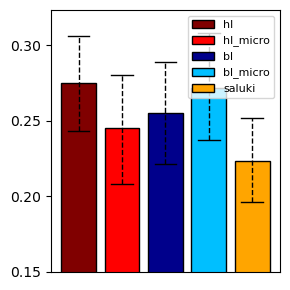

In [4]:
#Plot summary of performance metrics (AP); complex traits

import matplotlib.pyplot as plt

model_names = [
    'hl',
    'hl_micro',
    'bl',
    'bl_micro',
    'saluki',
]

model_accs = np.array([
    [0.275, 0.243, 0.306],
    [0.245, 0.208, 0.280],
    [0.255, 0.221, 0.289],
    [0.272, 0.237, 0.308],
    [0.223, 0.196, 0.252],
], dtype='float32')

model_colors = [
    'maroon',
    'red',
    'darkblue',
    'deepskyblue',
    'orange',
]

f = plt.figure(figsize=(3, 3))

x = np.arange(len(model_names), dtype='int32')

for i in range(len(model_names)) :
    plt.bar(x[i], model_accs[i, 0], color=model_colors[i], edgecolor='black', label=model_names[i])
    
    plt.plot([x[i] - 0.25, x[i] + 0.25], [model_accs[i, 1], model_accs[i, 1]], color='black', linestyle='-', linewidth=1)
    plt.plot([x[i], x[i]], [model_accs[i, 1], model_accs[i, 2]], color='black', linestyle='--', linewidth=1)
    plt.plot([x[i] - 0.25, x[i] + 0.25], [model_accs[i, 2], model_accs[i, 2]], color='black', linestyle='-', linewidth=1)

plt.ylim(0.15)

plt.xticks([], [])
plt.yticks([0.15, 0.20, 0.25, 0.30], fontsize=10)

plt.legend(fontsize=8)

plt.tight_layout()

plt.savefig('traitgym_complex_3prime.eps')

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


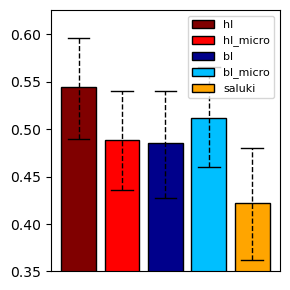

In [5]:
#Plot summary of performance metrics (AP); complex traits

import matplotlib.pyplot as plt

model_names = [
    'hl',
    'hl_micro',
    'bl',
    'bl_micro',
    'saluki',
]

model_accs = np.array([
    [0.545, 0.490, 0.596],
    [0.489, 0.436, 0.540],
    [0.485, 0.427, 0.540],
    [0.512, 0.460, 0.566],
    [0.422, 0.362, 0.480],
], dtype='float32')

model_colors = [
    'maroon',
    'red',
    'darkblue',
    'deepskyblue',
    'orange',
]

f = plt.figure(figsize=(3, 3))

x = np.arange(len(model_names), dtype='int32')

for i in range(len(model_names)) :
    plt.bar(x[i], model_accs[i, 0], color=model_colors[i], edgecolor='black', label=model_names[i])
    
    plt.plot([x[i] - 0.25, x[i] + 0.25], [model_accs[i, 1], model_accs[i, 1]], color='black', linestyle='-', linewidth=1)
    plt.plot([x[i], x[i]], [model_accs[i, 1], model_accs[i, 2]], color='black', linestyle='--', linewidth=1)
    plt.plot([x[i] - 0.25, x[i] + 0.25], [model_accs[i, 2], model_accs[i, 2]], color='black', linestyle='-', linewidth=1)

plt.ylim(0.35)

plt.xticks([], [])
plt.yticks([0.35, 0.40, 0.45, 0.50, 0.55, 0.60], fontsize=10)

plt.legend(fontsize=8)

plt.tight_layout()

plt.savefig('traitgym_mendelian_3prime.eps')

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


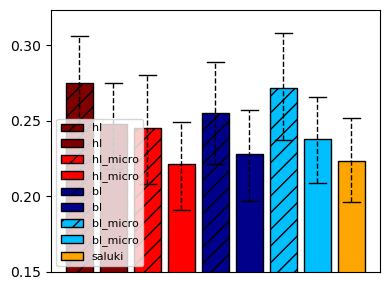

In [6]:
#Plot summary of performance metrics (AP); complex traits

import matplotlib.pyplot as plt

model_names = [
    'hl',
    'hl',
    'hl_micro',
    'hl_micro',
    'bl',
    'bl',
    'bl_micro',
    'bl_micro',
    'saluki',
]

model_hatches = [
    '//',
    None,
    '//',
    None,
    '//',
    None,
    '//',
    None,
    None,
]

model_accs = np.array([
    [0.275, 0.243, 0.306],
    [0.248, 0.218, 0.275],
    [0.245, 0.208, 0.280],
    [0.221, 0.191, 0.249],
    [0.255, 0.221, 0.289],
    [0.228, 0.197, 0.257],
    [0.272, 0.237, 0.308],
    [0.238, 0.209, 0.266],
    [0.223, 0.196, 0.252],
], dtype='float32')


model_colors = [
    'maroon',
    'maroon',
    'red',
    'red',
    'darkblue',
    'darkblue',
    'deepskyblue',
    'deepskyblue',
    'orange',
]

f = plt.figure(figsize=(4, 3))

x = np.arange(len(model_names), dtype='int32')

for i in range(len(model_names)) :
    plt.bar(x[i], model_accs[i, 0], color=model_colors[i], hatch=model_hatches[i], edgecolor='black', label=model_names[i])
    
    plt.plot([x[i] - 0.25, x[i] + 0.25], [model_accs[i, 1], model_accs[i, 1]], color='black', linestyle='-', linewidth=1)
    plt.plot([x[i], x[i]], [model_accs[i, 1], model_accs[i, 2]], color='black', linestyle='--', linewidth=1)
    plt.plot([x[i] - 0.25, x[i] + 0.25], [model_accs[i, 2], model_accs[i, 2]], color='black', linestyle='-', linewidth=1)

plt.ylim(0.15)

plt.xticks([], [])
plt.yticks([0.15, 0.20, 0.25, 0.30], fontsize=10)

plt.legend(fontsize=8)

plt.tight_layout()

plt.savefig('traitgym_complex_3prime_both_modes.eps')

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


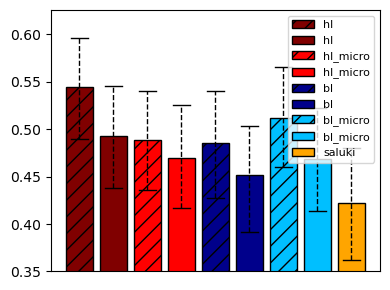

In [7]:
#Plot summary of performance metrics (AP); complex traits

import matplotlib.pyplot as plt

model_names = [
    'hl',
    'hl',
    'hl_micro',
    'hl_micro',
    'bl',
    'bl',
    'bl_micro',
    'bl_micro',
    'saluki',
]

model_hatches = [
    '//',
    None,
    '//',
    None,
    '//',
    None,
    '//',
    None,
    None,
]

model_accs = np.array([
    [0.545, 0.490, 0.596],
    [0.493, 0.438, 0.546],
    [0.489, 0.436, 0.540],
    [0.470, 0.417, 0.526],
    [0.485, 0.427, 0.540],
    [0.452, 0.392, 0.503],
    [0.512, 0.460, 0.566],
    [0.469, 0.414, 0.522],
    [0.422, 0.362, 0.480],
], dtype='float32')

model_colors = [
    'maroon',
    'maroon',
    'red',
    'red',
    'darkblue',
    'darkblue',
    'deepskyblue',
    'deepskyblue',
    'orange',
]

f = plt.figure(figsize=(4, 3))

x = np.arange(len(model_names), dtype='int32')

for i in range(len(model_names)) :
    plt.bar(x[i], model_accs[i, 0], color=model_colors[i], hatch=model_hatches[i], edgecolor='black', label=model_names[i])
    
    plt.plot([x[i] - 0.25, x[i] + 0.25], [model_accs[i, 1], model_accs[i, 1]], color='black', linestyle='-', linewidth=1)
    plt.plot([x[i], x[i]], [model_accs[i, 1], model_accs[i, 2]], color='black', linestyle='--', linewidth=1)
    plt.plot([x[i] - 0.25, x[i] + 0.25], [model_accs[i, 2], model_accs[i, 2]], color='black', linestyle='-', linewidth=1)

plt.ylim(0.35)

plt.xticks([], [])
plt.yticks([0.35, 0.40, 0.45, 0.50, 0.55, 0.60], fontsize=10)

plt.legend(fontsize=8)

plt.tight_layout()

plt.savefig('traitgym_mendelian_3prime_both_modes.eps')

plt.show()
